---
title: "Home Credit Project Summary"
format:
  html:
    toc: true
    code-fold: true
    code-summary: "Show the code"
    number-depth: 4
    number-sections: true
---

**Imports and settings:**

In [14]:
%reload_ext autoreload
%autoreload 1
import warnings
import joblib
import shap
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import auxiliary.eda_functions as eda
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
%aimport auxiliary.statistics
%aimport auxiliary.eda_functions

sns.set()
sns.set(font_scale=1.2)
BASE_FIG_SIZE=(8.5,4.5)
ALPHA=0.05

application_train=pl.read_csv('data/application_train.csv')
previous_application=pl.read_csv('data/previous_application.csv')
credit_card_balance=pl.read_csv('data/credit_card_balance.csv')
credit_data = pl.read_parquet("temp/active_credit_cards.parquet")

## Introduction

This project focuses on analyzing the Home Credit Group dataset, which is available [here](https://storage.googleapis.com/341-home-credit-default/home-credit-default-risk.zip). Home Credit Group, an international consumer finance provider, faces the challenge of assessing credit default risk for new applicants. The primary objective of this project is to develop machine learning models to address this challenge. Additionally, the project explores other potential areas where machine learning can enhance various aspects of the company's business operations.

### Tools and Methods

This project involves the application of various data science tools and methods to address the challenges presented by the Home Credit Group dataset:

- **Exploratory Data Analysis (EDA):** Matplotlib, Seaborn, and Polars libraries were used for EDA to analyze and visualize the dataset's characteristics and identify patterns.

- **Feature Generation:** Polars was utilized for feature generation from different data sources, contributing to the creation of relevant features for subsequent modeling.

- **Preprocessing Pipelines:** The preprocessing pipelines were developed based on the sklearn framework. Custom tools were created to maintain the Polars dataframe format up to the model, ensuring compatibility with the sklearn Pipeline format and preventing data leakage.

- **Hyperparameter Tuning:** Ray-Tune library facilitated the hyperparameter tuning process, allowing parallelization and early stopping for efficiency, especially with larger datasets.

- **Feature Selection:** BorutaShap library, combining the Boruta algorithm and Shap values, was employed for feature selection, helping to identify important features for modeling.

- **Modeling:** Sklearn and LightGBM models were applied for building predictive models to assess credit default risk, predict credit card over-limit situations, and determine consumer loan fees.

- **Feature Importance Evaluation:** The Shap library was used to evaluate feature importance, providing insights into the variables influencing model predictions.

- **Model Deployment:** FastAPI and Pydantic modules were employed for building the backend of the deployment. Streamlit was used for frontend development. Docker facilitated the containerization of both backend and frontend components.

- **Cloud Platform:** Google Cloud Platform Artifact Registry and Run tools were utilized for the final deployment of the models.


## Project Goals:

### Goal 1: Credit Default Risk

The primary objective of the first model is to predict whether the applicant will encounter challenges in repaying the loan.

**Displaying the target class balance:**

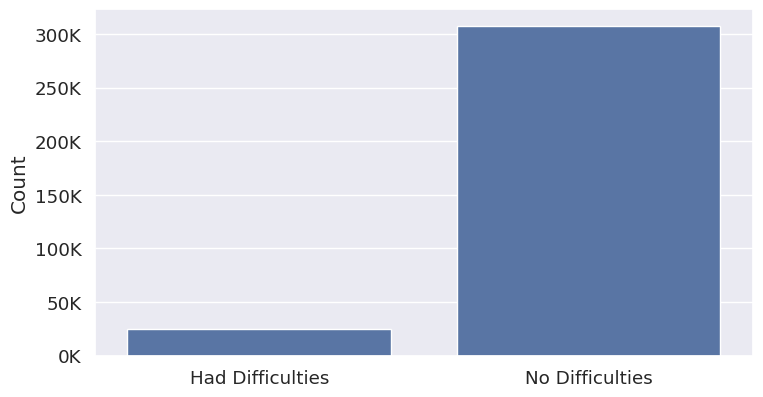

In [2]:
# | label: fig-target_balance
# | fig-cap: The number of applicants that had difficulties repaying their loan vs. those that had no difficulties.

fig_target_balance, ax_target_balance = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    [application_train["TARGET"].sum(), len(application_train["TARGET"])],
    ax=ax_target_balance,
)
ax_target_balance.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_target_balance.set_xticks([0, 1])
ax_target_balance.set_xticklabels(["Had Difficulties", "No Difficulties"])
ax_target_balance.set_ylabel("Count")
fig_target_balance.savefig("summary_data/target_balance_chart.png")
plt.show()

#### Success Criteria

During the Exploratory Data Analysis, it was revealed that the company leverages three external data sources, incurring associated costs. The external data, being scaled and exhibiting an approximately normal distribution, serves as the basis for establishing a success baseline. To gauge this baseline, a rudimentary classifier is applied to the data, and its performance is evaluated. Given the simplicity and effectiveness of logistic regression with this data – achievable with just a single line of code – it is considered a current attainable benchmark for the company.

**Logistic Regression ROC AUC score based on external data:**

In [3]:
imputer = SimpleImputer()
log_reg_model = LogisticRegression(class_weight="balanced")
pipeline = Pipeline([("imputer", imputer), ("model", log_reg_model)])
print(
    round(
        np.array(
            cross_val_score(
                pipeline,
                application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]],
                application_train["TARGET"],
                scoring="roc_auc",
            )
        ).mean(),
        3,
    )
)

0.719


With the logistic regression model yielding a roc-auc score of 0.719 based on external data, two success criteria: can be set:

* **Best Case:** Our model autonomously outperforms the external data score, without depending on additional external data.
* **Acceptable:** The incorporation of our model contributes to an improvement in the external data score.

### Goal 2: Credit Over Limit Prediction

During the EDA it was noted that some credit cards are over balance limit for the current month @fig-over-limit. Therefore, as an additional benefit, the construction of a model aiming to predict whether the current month's credit balance will exceed the limit for a specific credit card offers valuable advantages. This model can serve to proactively issue warnings to credit card holders, providing them with timely alerts. Simultaneously, it enables the company to assess and manage internal capital risks more effectively by anticipating and addressing potential over-limit situations before they occur.

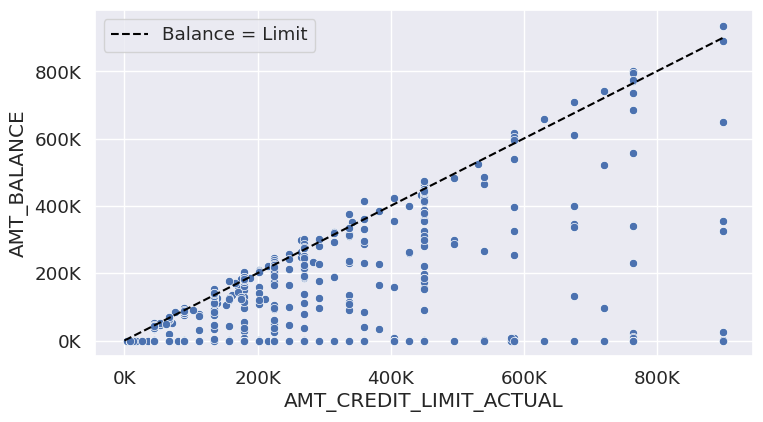

In [4]:
# | label: fig-over-limit
# | fig-cap: Credit card balance versus credit card limit for a random sample of n=1000. Points higher on the y-axis than the black line signify credit-cards over limit.
fig_balance, ax_balance = plt.subplots(figsize=BASE_FIG_SIZE)

sns.scatterplot(
    y=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_BALANCE"]
    .sample(1000, seed=1),
    x=credit_card_balance.filter(pl.col("AMT_CREDIT_LIMIT_ACTUAL") > 0)
    .group_by("SK_ID_CURR")
    .agg(pl.all().sort_by("MONTHS_BALANCE").last())
    .sort("SK_ID_CURR")["AMT_CREDIT_LIMIT_ACTUAL"]
    .sample(1000, seed=1),
    ax=ax_balance,
)

x_bal = np.linspace(0, 900000)
sns.lineplot(
    x=x_bal,
    y=x_bal,
    label="Balance = Limit",
    linestyle="--",
    color="black",
    ax=ax_balance,
)

ax_balance.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)
ax_balance.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x / 1000) + "K")
)

#### Success Criteria

Given the absence of existing methods for predicting credits over the limit, the success criteria for the new model will be grounded in the F-1 Score of a dummy classifier. This serves as a pragmatic benchmark for evaluating the model's performance in comparison to a simple baseline approach.

**Calculating the base-line F-1 score:**

In [5]:
dummy_credit = DummyClassifier(strategy="stratified")
print(
    "Success F-1 Score:",
    round(
        np.array(
            cross_val_score(
                dummy_credit,
                credit_data.drop(columns="IS_OVER_LIMIT"),
                credit_data["IS_OVER_LIMIT"],
                scoring="f1",
            )
        ).mean(),
        3,
    ),
)

Success F-1 Score: 0.129


### Goal 3: Consumer Loan Fees Prediction

During the EDA it was discovered that different loans come with different fees for the consumer that involve a composite of interest rate and additional fees (@fig-fees). The third model in this project focuses on determining the proportion of these fees specifically for consumer loans, based on the data in the previous application table.

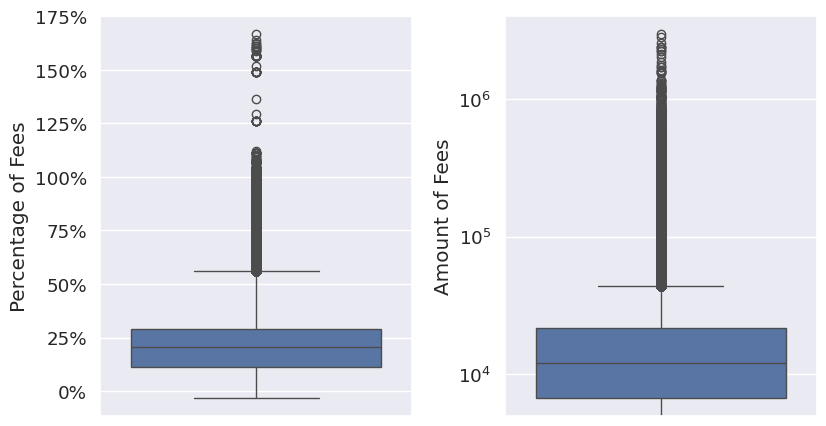

In [6]:
# | label: fig-fees
# | fig-cap: The proportion and amount of fees that the consumer pays on their consumer loan in the addition to the principal loan amount.

consumer_loans = previous_application.filter(
    (pl.col("NAME_CONTRACT_TYPE") == "Consumer loans")
    & (pl.col("NAME_CONTRACT_STATUS") == "Approved")
)

# Irrelevant cols
consumer_loans = consumer_loans.drop(
    columns=["NAME_YIELD_GROUP", "NAME_CONTRACT_STATUS", "NAME_CONTRACT_TYPE"]
)

consumer_loans = consumer_loans.with_columns(
    ((pl.col("AMT_ANNUITY") * pl.col("CNT_PAYMENT") - pl.col("AMT_CREDIT"))).alias(
        "FEES_AMT"
    )
)

consumer_loans = consumer_loans.with_columns(
    (
        (pl.col("AMT_ANNUITY") * pl.col("CNT_PAYMENT") - pl.col("AMT_CREDIT"))
        / pl.col("AMT_CREDIT")
        * 100
    ).alias("FEES_PERCENT")
)
consumer_loans = consumer_loans.drop_nulls("FEES_PERCENT")

fig_fees, ax_fees = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)

sns.boxplot(consumer_loans["FEES_PERCENT"], ax=ax_fees[0])
ax_fees[0].set_ylabel("Percentage of Fees")
ax_fees[0].yaxis.set_major_formatter(ticker.PercentFormatter())

sns.boxplot(consumer_loans["FEES_AMT"], ax=ax_fees[1])
ax_fees[1].set_yscale("log")
ax_fees[1].set_ylabel("Amount of Fees")
plt.tight_layout()
plt.show()

#### Success Criteria

Given that the model is intended to serve as a suggestive tool for loan profitability and fee determination, the success criteria will be established based on a baseline. Since there is currently no specific information on how to determine these fees, the baseline will be determined by the RMSE (Root Mean Square Error) from either the overall median or mean of fees, depending on which yields a more favorable result. This approach provides a practical benchmark for assessing the model's performance in the absence of a predefined fee determination method.

In [7]:
rmse_mean_fees = mean_squared_error(
    consumer_loans["FEES_PERCENT"],
    consumer_loans.with_columns(pl.col("FEES_PERCENT").mean().alias("mean"))["mean"],
    squared=False,
)

rmse_median_fees = mean_squared_error(
    consumer_loans["FEES_PERCENT"],
    consumer_loans.with_columns(pl.col("FEES_PERCENT").median().alias("median"))[
        "median"
    ],
    squared=False,
)

print("RMSE from Median Fee:", round(rmse_median_fees, 2))
print("RMSE from Mean Fee:", round(rmse_mean_fees, 2))

RMSE from Median Fee: 13.16
RMSE from Mean Fee: 13.06


The base-line RMSE will be 13.06, based on the mean fee RMSE.

## Insights from EDA

### Application table analysis

The exploratory data analysis (EDA) conducted, as outlined in the EDA.ipynb file, unveiled several crucial insights into the dataset.

1. The exploration involved investigating the database schema (@fig-schema). Notably, it was observed that certain features in the main application table could have up to 69% of values missing. The highest occurrences of missing values were found in various home characteristics, such as "common area."

2. An assessment of the number of references applicants have in other tables revealed that most applicants have information about them in the credit bureau and had previous loan applications.

3. In pursuit of identifying promising features, an initial CatBoost test was performed, and the top 10 features are displayed in @tbl-initial_features.

4. The EDA delved into the distributions of these features and their relationships with the target variable. This exploration involved graphical inspection as well as statistical inference using chi-squared and Kruskal-Wallis tests to gauge the direct statistical relationships with the target.

![Database schema.](summary_data/home_credit.png){#fig-schema}

In [8]:
# | label: tbl-initial_features
# | tbl-cap: Ten most important features based on a quick scan with catboost.
initial_test = joblib.load("summary_data/initial_test.joblib")
eda.table_display(initial_test["features"][:10])

| feature                |   importance |
|:-----------------------|-------------:|
| EXT_SOURCE_3           |      9.49508 |
| EXT_SOURCE_2           |      8.94928 |
| EXT_SOURCE_1           |      5.76733 |
| DAYS_BIRTH             |      5.26519 |
| AMT_CREDIT             |      4.33955 |
| AMT_ANNUITY            |      3.99456 |
| DAYS_ID_PUBLISH        |      3.91373 |
| DAYS_EMPLOYED          |      3.47728 |
| DAYS_LAST_PHONE_CHANGE |      3.47288 |
| AMT_GOODS_PRICE        |      3.23805 |

### Credit Bureau Data

During the exploration of the credit bureau data it was determined that:

1. Applicants can possess both active and closed credits.
2. Active credits exhibit overdue status, with some cases extending over several years.
3. Overdue credits vary significantly in terms of currency, ranging from hundreds to millions.
4. The credit bureau retains several years' worth of credit information for each applicant.
5. Notably, a majority of the information within the credit bureau has been recently updated.
6. The information in credit bureau is in three different currencies, the majority of entries are in currency 1. The currencies differ in scale and there is no information about the exchange rate, therefore only amount information with currency 1 will be aggregated into features.

### Previous Application Data

During the exploration of previous applications it was determined that:

1. Applicants have a history of up to 70 rejected previous applications and up to 30 accepted previous applications.
2. Although the majority of previous applications were submitted in the last couple of years, some date back as far as 8 years.
3. Instances of late or underpaid installments were observed in some of the previous applications.

Furthermore, this section gave ideas for two additional goals in this project:

1. Goal 2: Credit card balance over limit prediction.
2. Goal 3: Consumer loan fee prediction.

## Feature Generation

### Features for Model 1: Default Risk Prediction

Feature generation for model 1 can be found as feature_generation_model_1.ipynb

Aggregating historical and other information about applicants from various tables, including the credit bureau and previous application data, was a crucial step in preparing the data for default risk prediction. The process of aggregation was executed through a series of steps, the details of which are outlined in this section.

#### Credit Bureau Data

Various sets of features were derived from the credit bureau data:

1. Numeric variables from the credit bureau table were incorporated as features, utilizing different aggregation methods (mean, min, max, sum, std) after grouping by the current applicant ID. This process was performed both for the entire dataset and separately for active applications.
2. The count of credits (active, closed, sold) for each applicant was introduced as additional features.
3. The most prevalent credit types for the applicant in the credit bureau were appended as features for both the overall dataset and active applications separately.
4. The last balance status for each entry in the bureau was included, and the most common value for each applicant was incorporated as a feature.
5. The sum of days past due for each applicant was added as features, considering both the total and active-only applications separately.

#### Previous Application Data

The features added based on previous applications encompass the following:

1. Sum and mean aggregations of previous credits were computed, categorized by status and type.
2. The count of accepted and rejected previous applications for each current applicant was introduced as features.
3. The total amount remaining to be paid for active previous loan applications was calculated using information from the POS cash balance table and subsequently added as a feature.
4. Both the total credit card balance and the total credit card balance exceeding the limit were incorporated as additional features.

#### Behavioral Data

Various aggregations (mean, max, sum) of days overdue and the amount underpaid for previous installments were introduced as features.

#### Initial Feature Selection

After the feature generation phase, a total of 289 independent variables were amassed. Recognizing that some of these variables might not contribute significant value and aiming to enhance the efficiency of subsequent feature selection and modeling steps, initial quick feature elimination was undertaken. This process involved assessing variance and identifying potential collinearity among variables, facilitating the identification and removal of redundant or less informative features.

##### Low Variance Features

Several Boolean features were subjected to removal based on low variance, with the variance threshold set below 0.001. The largest minority class within this subset of features contained 183 samples.

##### Highly Correlated Features

To address high multicollinearity, a pragmatic approach was adopted, acknowledging that interpretability was not the primary goal. A notably high threshold of 0.999 for Spearman's rank coefficient was selected. The aim was to eliminate only those features that conveyed nearly identical information, considering that certain features might have been generated using similar aggregation techniques.

The identification of clusters of multicollinear features was accomplished through correlating pair clustering using the NetworkX library. Subsequently, only the first member of each cluster was retained, and the others were removed.

After initial feature selection there were 232 features left.

### Feature Generation Model 2: Credit Card Over Limit Prediction

Feature generation for model 2 can be found in feature_generation_model2-3.ipynb

#### Historical Data

Behavioral data for the same credit card was incorporated as features:

1. **Length of Credit Card History:** Reflects the duration of the credit card's history, providing insights into the long-term behavior.

2. **Aggregations of Over-Limit Instances:** Various aggregations of the times the credit card exceeded its limit in the past, offering a behavioral perspective on credit card usage patterns.

#### Application attributes

The different attributes in the application for the specific credit card were added from the current application table.

#### Payment Behavioral Data

The number of days late and the amount underpaid for previous credit card installments were aggregated using different functions and added to the credit card data as features.

#### Application Weekday

The weekday of the application was encoded as it's sine and cosine.

#### Current Status

Current characteristics of the applicant were gathered from the application table.

#### Initial Feature Selection

The features were filtered for low variance and high multicollinearity.

A total of 61 features was gathered.

### Model 3: Consumer Loan Fees

For the consumer loans model, features were exclusively derived from the previous application table. Historical data was deemed irrelevant since this model focuses on predicting loan fees at the time of application, narrowing the feature set to those directly associated with the current application.

The features underwent filters for low variance and high correlation. A total of 20 features was gathered.

## Models

### Model 1: Credit Default Risk.

This section describes the construction of the credit default risk model pipeline and it's testing.

#### Preprocessing Pipeline

The preprocessing pipeline involved several key steps:

1. **Handling Missing Values in Numeric Features:** Null values in numeric features are encoded as a distinct number deviating from the rest. The sign of this deviation is determined by comparing the target mean of the nulls to the rest of the data, taking into account the sign of Pearson's correlation coefficient.

2. **Pooling Classes in Categorical Features:** Classes in categorical features with fewer than 100 values are consolidated into an "other" class.

3. **One-Hot Encoding for Boolean Features:** Boolean features are encoded using one-hot encoding, transforming them into binary representations.

4. **Labeling Categorical Features:** Categorical features are assigned numerical labels, and the order is determined by the target mean in the training set.

5. **Feature Removal Transformer:** A feature removal transformer is integrated into the pipeline to facilitate testing different sets of features during the parameter tuning phase. This allows for experimentation with various feature subsets to optimize model performance.

6. **Oversampling Technique:** An optional oversampling technique, involving optional random oversampling of the minority class was incorporated into the pipeline. This decision is tuned alongside hyperparameters for each model.

The strategy of encoding null values as a specific category, such as representing no credit history (neither good nor bad), is a pragmatic approach, especially when working with decision tree-based models. These models typically handle null values encoded as "something else" well, treating them as a separate category during the split decisions.

However, it's crucial to acknowledge the potential downside of this approach. If null values appear in the future due to a lack of data collection rather than the absence of the underlying phenomenon, the model's robustness could be compromised. In such cases, as data collection improves and more information becomes available, it might be necessary to update the model. Additionally, different imputation techniques could be considered for specific features with missing data due to reasons other than the actual absence of the phenomenon. Regular model updates and adaptations to changing data scenarios are essential practices for maintaining the model's accuracy and relevance over time.

#### Models

Three distinct models were assessed for their predictive performance:
1. LGBM Classifier
2. Extra Trees
3. Regularized Greedy Forest

#### Feature Selection

The Boruta Algorithm, utilizing SHAP values, was employed for feature selection through three runs with LGBM, each using different alpha regularization values. The consensus from these experiments categorized features into good, tentative, and bad. Tuning was performed for two feature removal options alongside hyperparameters: removing only bad features and removing both bad and tentative features.

#### Hyperparameter Tuning and Model Selection


Hyperparameter tuning was executed with the Ray-Tune library using the Optuna algorithm. The primary metric for tuning was ROC-AUC, evaluated with up to 5 stratified k-fold cross-validations for each promising trial. The full training set was utilized for this process, with the exception of the RGF model, where a subsample of 100,000 was employed.

The models' performance was evaluated alongside a stacked model incorporating all three models (@fig-model1-selection). The Regularized Greedy Forest (RGF) model demonstrated the most success, attributed to its superior performance and stability.

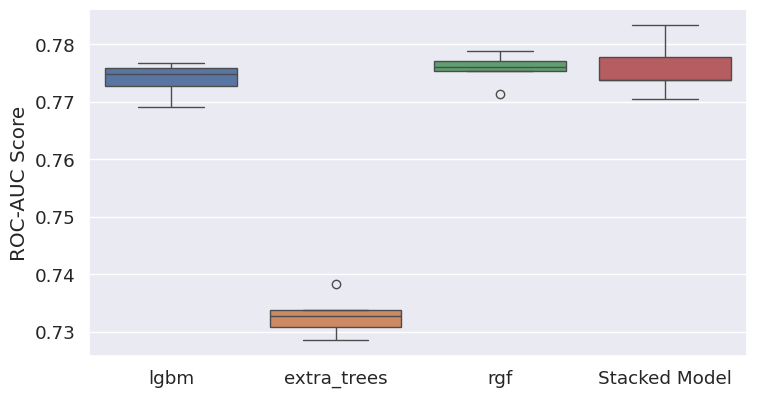

In [9]:
# | label: fig-model1-selection
# | fig-cap: ROC-AUC scores based on 5 stratified kfold cross-validations for the models tested in this project.

warnings.filterwarnings("ignore", category=UserWarning)
scores = joblib.load("temp/model_1_base_scores.joblib")
stacked_model_scores = joblib.load("temp/stack_scores.joblib")
scores = scores.with_columns(pl.Series(stacked_model_scores).alias("Stacked Model"))
fig_scores_full, ax_scores_full = plt.subplots(figsize=BASE_FIG_SIZE)
sns.boxplot(scores, ax=ax_scores_full)
ax_scores_full.set_xticklabels(scores.columns)
ax_scores_full.set_ylabel("ROC-AUC Score")
plt.show()

#### Model Testing

The selected model was tested by making predictions on the test set without target information and submitting a Kaggle submission. The model performed well, achieving a ROC-AUC score of 0.767, surpassing the baseline of 0.719.

Subsequently, the model was trained on data with missing external source features, achieving a ROC-AUC score of 0.749, once again exceeding the baseline.

These results indicate that the model fully meets the success criteria, demonstrating its ability to outperform predictions based on external sources without utilizing them directly.

### Feature Importance Interpretation

The features were evaluated based on the models internal feature importance and shap values on a sample of the data. The shap value summary plot for a subset of 300 samples can be found in @fig-model1-shap.

The model's internal values highlight key features related to the applicant's background and credit history:

1. **Number of Days Since Last Credit Application:** Reflects the recency of the applicant's credit activity.

2. **Applicant Occupation:** The nature of the applicant's occupation is a crucial determinant.

3. **Employment Length:** Duration of the applicant's employment influences predictions.

4. **Age:** Applicant's age correlates with credit risk.

5. **Education:** The level of education contributes to default risk assessment.

6. **Location:** Geographical location significantly influences predictions.

7. **Loan Size:** The size of the loan sought is critical for default risk prediction.

8. **Amount of Credit in Previously Refused Applications:** Captures credit amounts in prior rejected applications.

9. **Sum of Current Debt:** Total current debt is an influential predictor.

Additionally, SHAP value analysis for a subset highlighted the importance of when the applicant last changed their ID and the type of organization where the client works and the count of active credits from the credit bureau.

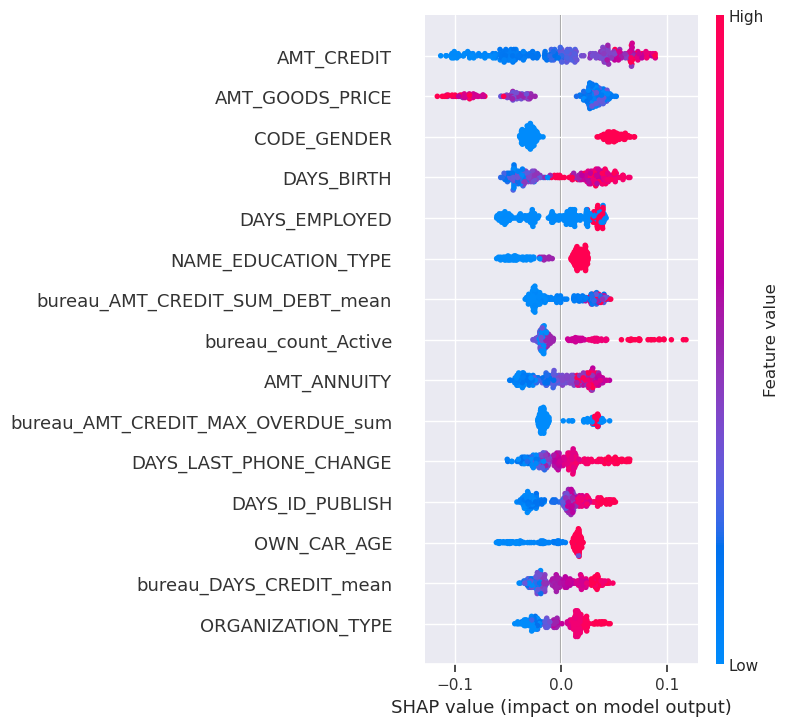

In [10]:
# | label: fig-model1-shap
# | fig-cap: Shap Value bee swarm plot for a subset of 300 samples from the test set. Positive probability values impact applications with default risk.
shap_model1 = joblib.load("summary_data/shap_model1.joblib")
shap.summary_plot(
    shap_model1["shap_vales"][:, :, 1],
    shap_model1["sample_data"].to_numpy(),
    feature_names=shap_model1["names"],
    max_display=15,
)

### Model 2: Credit Card Over-Limit

The notebook for this section can be found as model_2_credit_limit.ipynb

Given the nature of this problem involving both categorical and numerical features, along with missing values and a non-parametric distribution of numeric features, the LightGBM model was selected. This choice was driven by its precision, speed, and robustness across diverse types of data, making it well-suited for the complexities of this particular task.

#### Preprocessing Pipeline

For model 2, a similar preprocessing approach was adopted, treating missing values as separate categories. The notable addition was the inclusion of MinMax Scaler to leverage advanced oversampling techniques like SMOTE or ADASYN. The preprocessing steps are as follows:

1. **Weekday Cyclical Encoding:** Encode weekdays using sine and cosine functions to capture cyclical patterns.

2. **One-Hot Encoding for Boolean Features:** Transform boolean features into binary representations using one-hot encoding.

3. **Labeling Categorical Features:** Assign numerical labels to categorical features based on the target mean in the training set.

4. **Min Max Scaler:** Apply MinMax scaling to standardize all data.

5. **Null Imputer:** Impute null values with -1.

6. **Feature Removal Transformer:** Integrate a feature removal transformer into the pipeline for testing different feature subsets during parameter tuning.

7. **Oversampling Technique:** Optional oversampling techniques, including random oversampling, SMOTE, and ADASYN, are incorporated into the pipeline. The choice is tuned alongside hyperparameters for each model.

#### Feature Selection

Similar to the previous section, feature selection was conducted using Boruta SHAP. Multiple runs with varying strictness (percentiles ranging from 20 to 100) were executed, generating lists of features to be removed. During the tuning process, the selection of features to be removed was performed in conjunction with model hyperparameters, optimizing the overall performance of the model.

#### Hyperparameter Tuning
The hyperparameters were fine-tuned using the Ray-Tune library and the Optuna algorithm for optimization. Model evaluation relied on 5-fold stratified cross-validation, emphasizing the F1-score for the positive class (credit card over-limit) as the primary metric. Optimal choices included 35 feature removal, oversampling with ADASYN, and LightGBM with the DART algorithm.

#### Model Testing
The model achieved an F1-Score of 0.63 greatly beating our previously set base line and success criteria of 0.128. The model performed better at identifying the majority class (credit card balance within limits) as seen in @fig-confusion-credit.

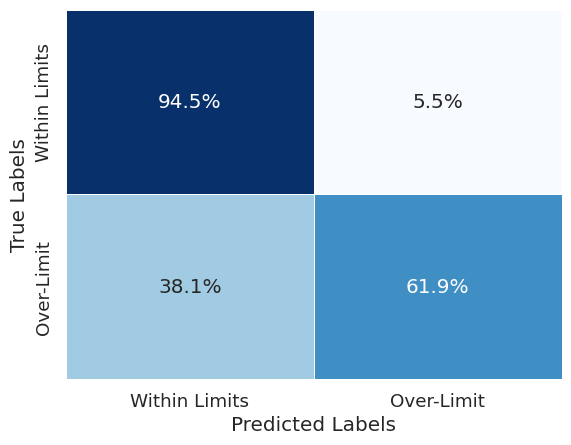

In [11]:
# | label: fig-confusion-credit
# | fig-cap: The confusion matrix of model 2, normalized by class size.
confusion = joblib.load("summary_data/model2_confusion.joblib")
class_labels = ["Within Limits", "Over-Limit"]

sns.heatmap(
    confusion,
    annot=True,
    fmt=".1%",
    cmap="Blues",
    linewidths=0.5,
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### Feature Importance
The analysis of feature importance using SHAP values (@fig-model2-shap) revealed the following key factors:

1. **Installment Size:** Higher installments correlated with a higher likelihood of credit cards going over the limit.

2. **Credit Card Limits:** Credit cards with larger limits exhibited a lower tendency to go over the limit.

3. **Historic Over-Limit Data:** The frequency of past instances of going over the limit, as well as the sum and mean of the amount over the limit, indicated a higher probability of exceeding the limit in the current month.

4. **Length of Credit Card History (HISTORIC_NUM_ENTRIES):** A longer credit card history suggested greater trustworthiness.

5. **Income:** Larger incomes were associated with better financial discipline.

6. **Amount Annuity:** Values for annuity had non-obvious directional trends, possibly contributing as a conditional feature.


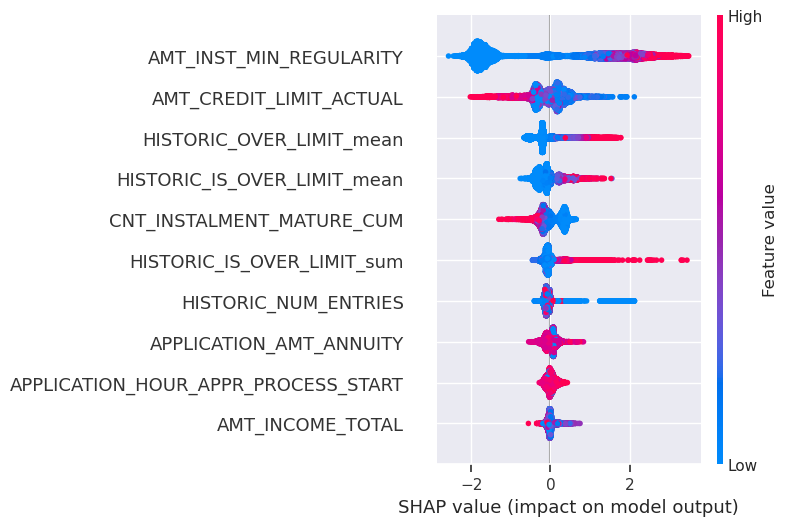

In [12]:
# | label: fig-model2-shap
# | fig-cap: SHAP values of ten most valuable features in the credit card limit model.
model2_shap = joblib.load(
    "summary_data/shap_model2.joblib",
)

shap.summary_plot(
    model2_shap["shap_vales"],
    model2_shap["sample_data"].to_numpy(),
    feature_names=model2_shap["names"],
    max_display=10,
)

### Model 3: Consumer Loan Fee Prediction
The notebook for this section can be found as model_3_consumer_loan_fee.ipynb

Considering that the consumer loan fee prediction model is intended for eventual use in price determination, interpretability and transparency were prioritized alongside accuracy. Consequently, only the simplest models—linear regression with either ridge or lasso regularization and a decision tree—were tested.

#### Preprocessing Pipelines

The preprocessing pipeline for the linear models included:

1. Pooling classes in categorical features with fewer than 300 samples into the "Other" class.
2. One-hot encoding of categorical features.
3. Imputation of missing values in numeric features (Down payment and insurance) as 0, based on common sense.
4. Standard scaling.

For the decision tree model, the preprocessing pipeline differed:

1. Label encoding with the order of the labels set by the target mean was used instead of one-hot encoding.
2. The scaler was omitted.

#### Hyperparameter Tuning
With only 18 features initially, no feature removal step was conducted. Instead, the tuning focused on the regularization parameters for the linear models and the decision tree's depth and minimum samples for a leaf split to counteract overfitting. Hyperparameter tuning was executed using the Ray-Tune library with the Optuna algorithm. The models with specific parameter sets were validated through 5-fold cross-validation, utilizing RMSE as the evaluation metric.

#### Model Selection and Testing

The decision tree significantly outperformed the linear models, as evident in @fig-fee-compare. This discrepancy is likely attributed to the non-parametric distribution of the data and the presence of conditional factors. A more detailed analysis of each feature and appropriate transformations to make them more suitable for linear models could potentially enhance the results. Further investigation into feature engineering and transformation strategies may be beneficial for improving the performance of linear models in this context.

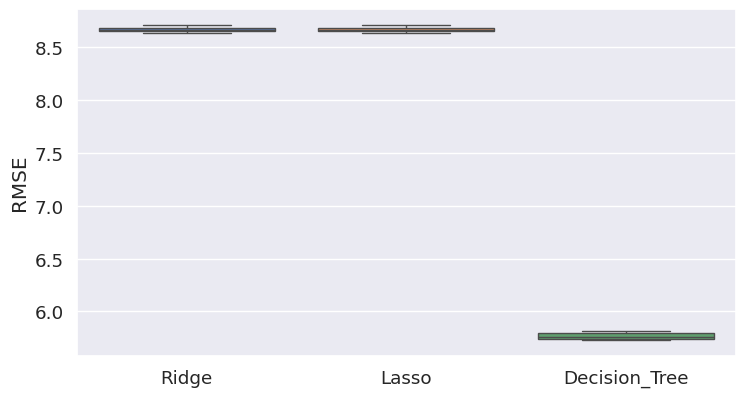

In [13]:
# | label: fig-fee-compare
# | fig-cap: The comparison of RMSE from five K-fold cross-validations on linear regression and decision tree models.
fig_rmse_all, ax_rmse_all = plt.subplots(figsize=BASE_FIG_SIZE)
rmse_all = joblib.load("summary_data/rmse_model3.joblib")
sns.boxplot(rmse_all, ax=ax_rmse_all)
ax_rmse_all.set_xticklabels(rmse_all.columns)
ax_rmse_all.set_ylabel("RMSE")
plt.show()

The decision tree model achieved an RMSE value of 5.70, surpassing our baseline of 13.06. The model exhibited consistent performance across the target value spectrum, as depicted in @fig-residual-plot, and the mean of the residuals was approximately 0. This indicates that the model performed well in predicting loan fees and produced residuals with a balanced distribution around zero.

![Left: predicted vs. true values. Right: The dependance of residuals on the predicted value.](summary_data/error_plot.png){#fig-residual-plot}

#### Feature Importance

The feature importance was assessed using SHAP value analysis (@fig-model3-shap). The analysis revealed that the model bases its decisions primarily on:

1. The term of the loan.
2. The loan amount.
3. The nature of the product for which the consumer loan is intended.
4. The down payment.
5. The location and characteristics of the seller.


![Shap value analysis of the ten most valuable features in the consumer loan prediction model.](summary_data/shap_model3.png){#fig-model3-shap}

## Deployment

For the deployment demonstration, the third model utilized FastAPI with Pydantic for the backend. The backend was containerized with Docker and uploaded to Google Cloud Artifacts. It is deployed [here](https://fee-prediction-backend-ubfu2xlf7q-oe.a.run.app/).

The front end was developed using Streamlit, containerized, and uploaded to Google Cloud Run. The app can be accessed [here](https://frontend-ubfu2xlf7q-oe.a.run.app/).


## Conclusions
* The company can effectively employ machine learning algorithms, even without external source data, to predict credit default risk with satisfactory accuracy.
* A predictive model for assessing whether a credit card will exceed its limit can be developed, offering a means to issue warnings to cardholders and evaluate internal financial risks for the company.
* A Decision Tree model, with further enhancements, holds potential for automatically generating consumer loan prices.

### Further Improvements
* Generate additional features for the credit default risk model using deep learning to capture complex patterns and relationships from different data sources.
* Perform an additional hyperparameter tuning cycle specifically for the credit default risk model after removing external source data.
* Conduct a detailed analysis of the model's performance on different segments of the data to identify potential areas for improvement.
* Evaluate the pricing of loans considering potential losses in the event of credit default, and fine-tune the decision threshold based on business metrics.